In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Presentation
Upselling Marketing use case: from a pool of free users identification of a segment likely to pass premium. The context is a company building a product offering peer to peer payment with a freemium business model.


The dataset is composed of the data of 300 000 users with 20% of them being paying users. 
Provided that we have the budget to advertise to only 2000 users, the goal of this project is to identify the users most likely to pass premium. The identification will be done in 2 differents ways, first using a clustering algorithm (unsupervised learning) and then using a learning algorithm (supervised learning). 




In [2]:
data = pd.read_csv('dataset.csv') #loading the dataset

# I. Data exploration

## a. Dataset examination 

In [3]:
data.shape

(300000, 13)

The dataset is composed of 300 000 lines and 13 columns, let's take a closer look

In [4]:
data.sample(10)

,Unnamed: 0,phone_price,age,phone_model_ios,nb_p2p,nb_card,place,model_age,card_type,bank,connection_hour,session_time,premium_target
173505,173505,384.123398,28.951482,1,0,9,3,5.987049,1,1,8.380567,4.541168,0
55644,55644,362.153797,24.315440,0,0,7,3,3.544979,3,1,9.912809,3.910388,0
78539,78539,348.293265,19.254619,0,1,6,2,3.350439,2,1,16.006345,0.632261,0
289144,289144,422.810048,25.474235,1,0,11,3,5.250797,2,1,10.346689,9.237411,0
267465,267465,418.580036,19.214780,1,4,9,3,8.506649,2,1,18.683226,3.259634,0
24946,24946,393.158082,19.152111,0,0,8,2,1.929867,2,1,21.572065,1.520854,0
49320,49320,642.512019,24.982600,1,3,4,3,2.137567,1,1,8.736116,5.136052,0
189510,189510,439.584508,25.478958,1,3,8,3,4.974620,3,2,14.703147,5.126133,1
149457,149457,638.833407,18.569219,0,0,8,2,4.188367,1,2,23.000000,7.247531,1
276406,276406,330.051886,30.007411,0,0,7,3,4.838795,2,2,4.358442,10.674116,0


The unnamed column appears to be the number of the row, let's drop it as we already have an index. 

In [5]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [6]:
data.describe()

,phone_price,age,phone_model_ios,nb_p2p,nb_card,place,model_age,card_type,bank,connection_hour,session_time,premium_target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,400.462666,24.993482,0.699957,2.484657,14.299830,2.501877,4.760180,1.870300,1.658433,12.111787,6.370568,0.206947
std,126.717034,6.966344,0.458277,3.682252,8.833029,0.670700,2.855498,0.795148,0.805478,5.935800,4.376812,0.405118
min,70.329749,18.000089,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.181755,0.000951,0.000000
25%,309.295934,20.005996,0.000000,0.000000,8.000000,2.000000,2.723228,1.000000,1.000000,7.282888,3.225788,0.000000
50%,386.962856,22.852131,1.000000,1.000000,12.000000,3.000000,4.550915,2.000000,1.000000,11.074185,5.394622,0.000000
75%,477.037218,27.700800,1.000000,3.000000,18.000000,3.000000,6.515689,3.000000,2.000000,16.745190,8.438145,0.000000
max,1242.371329,68.000000,1.000000,84.000000,50.000000,3.000000,29.849531,3.000000,3.000000,23.000000,47.625733,1.000000


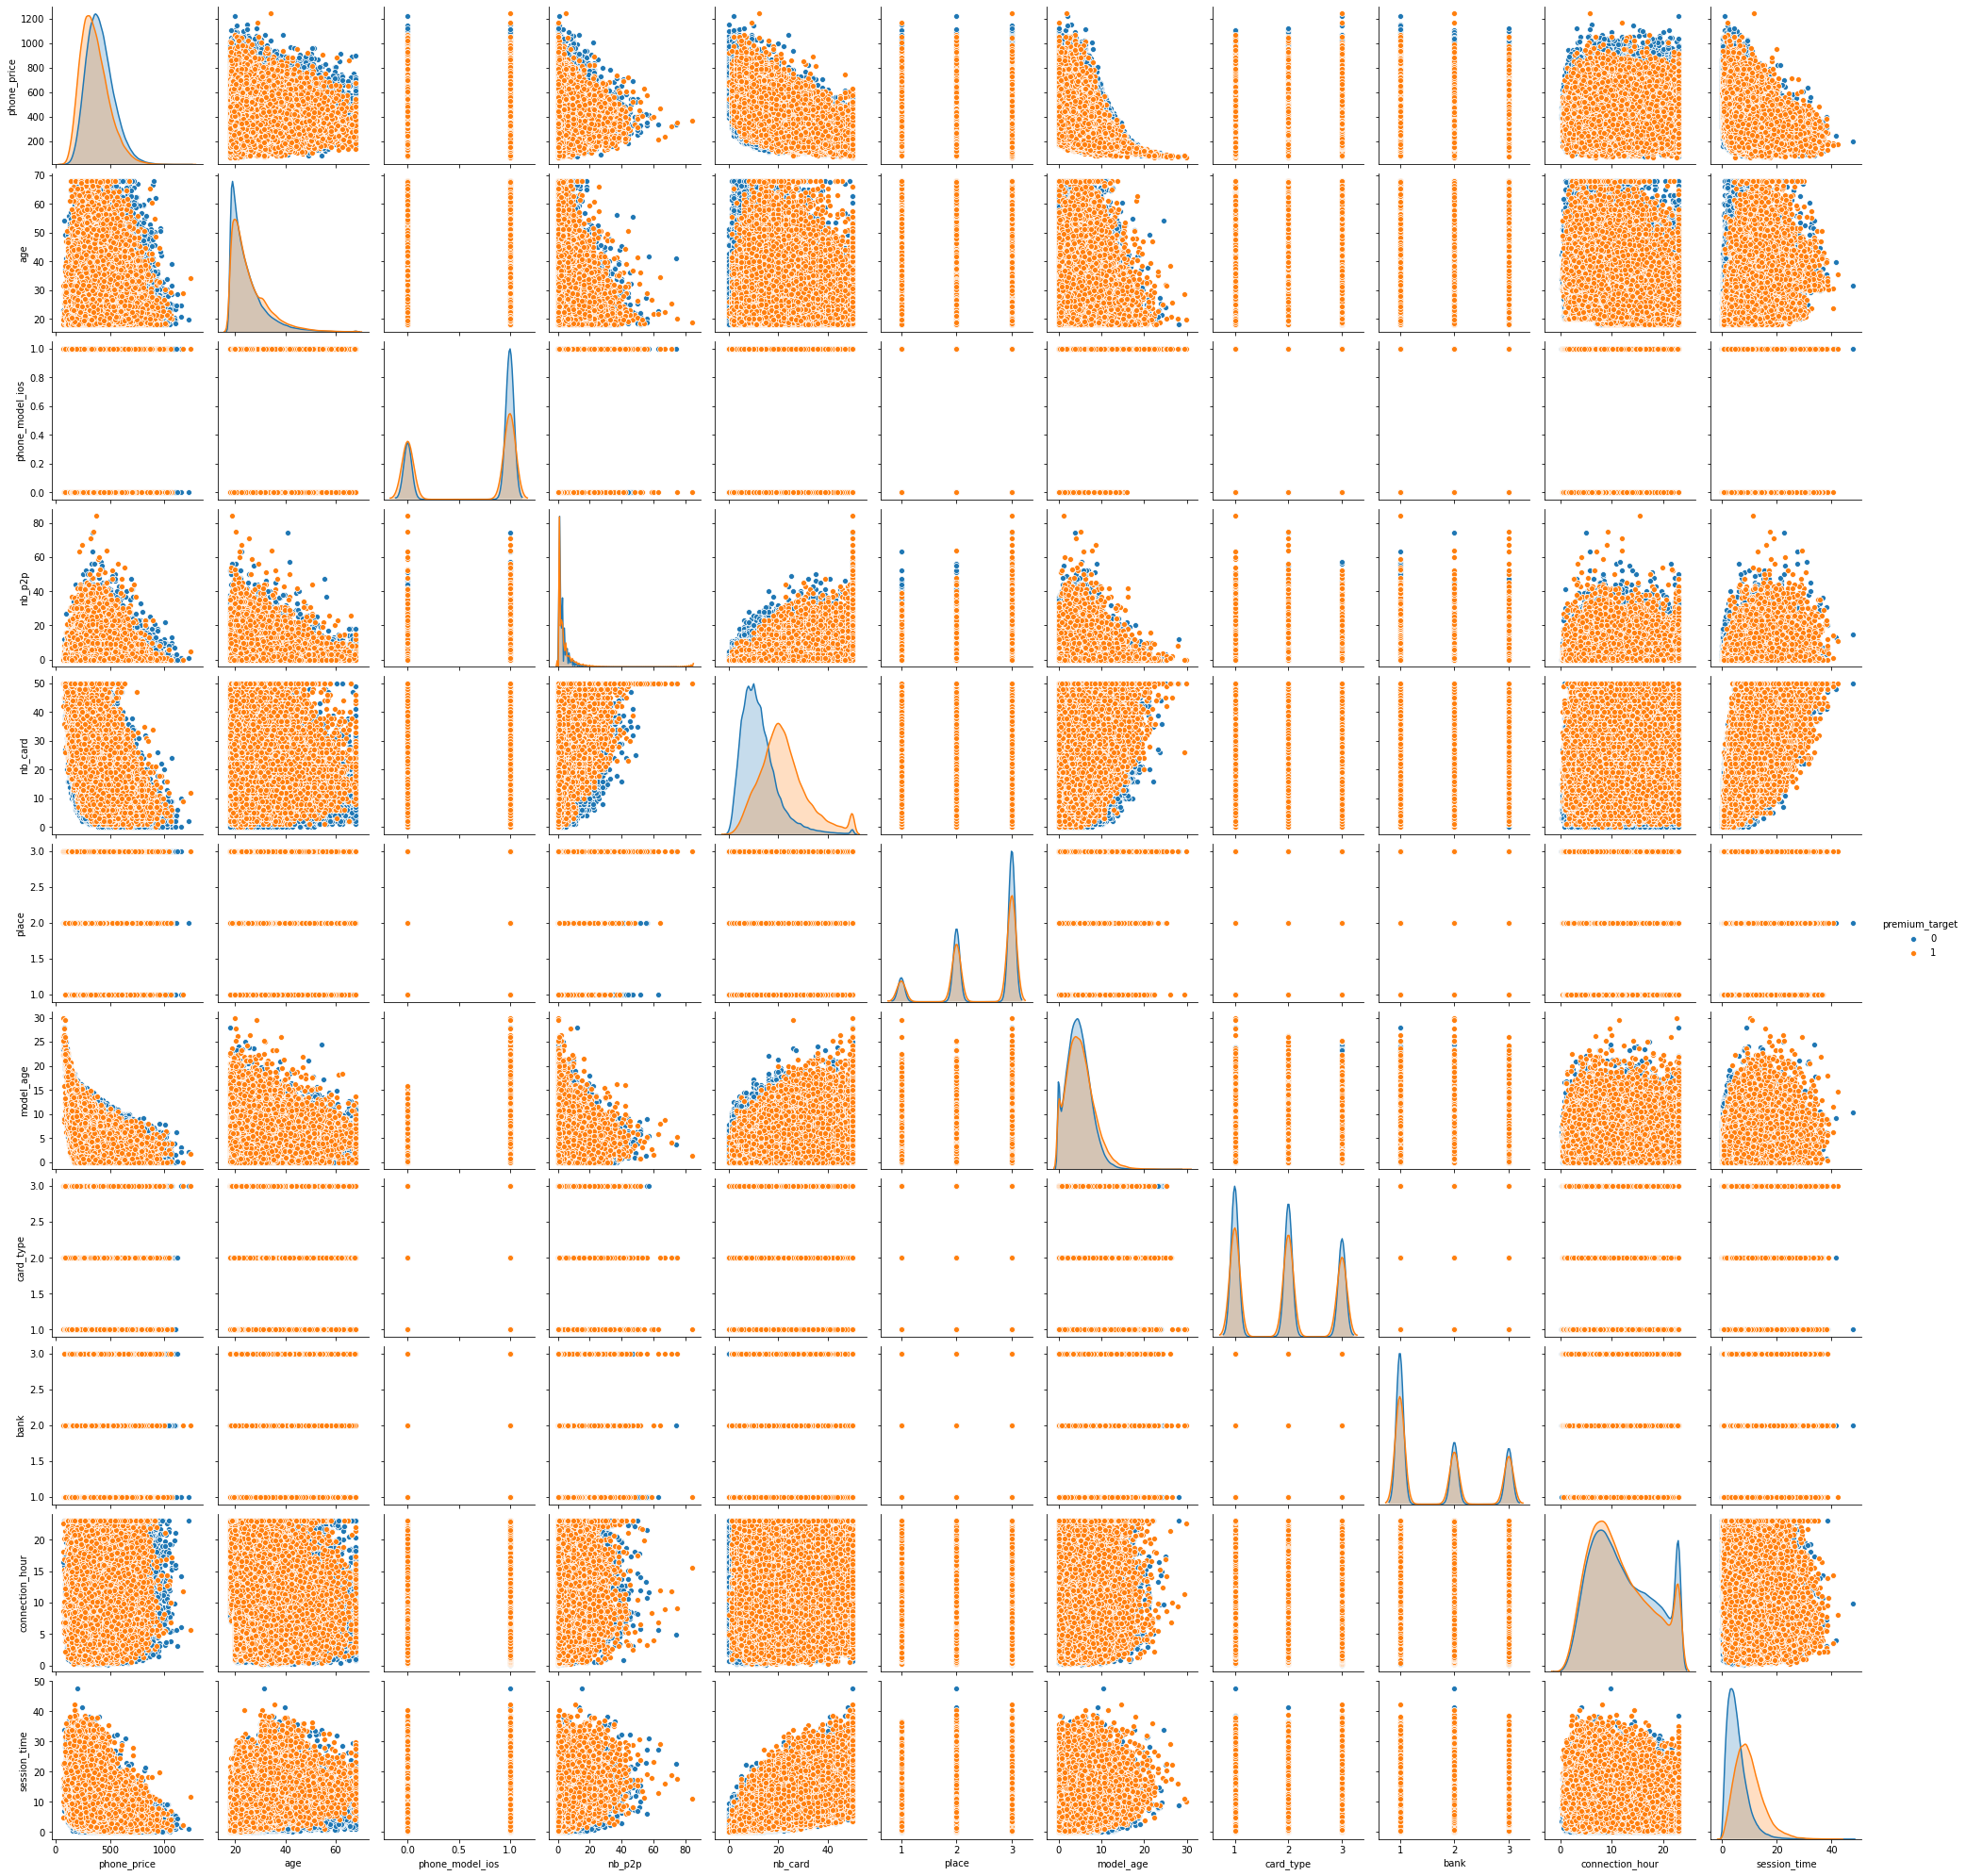

In [7]:
sns.pairplot(data, hue="premium_target")

The pairplot reveals no obvious way of separating paying from free users...

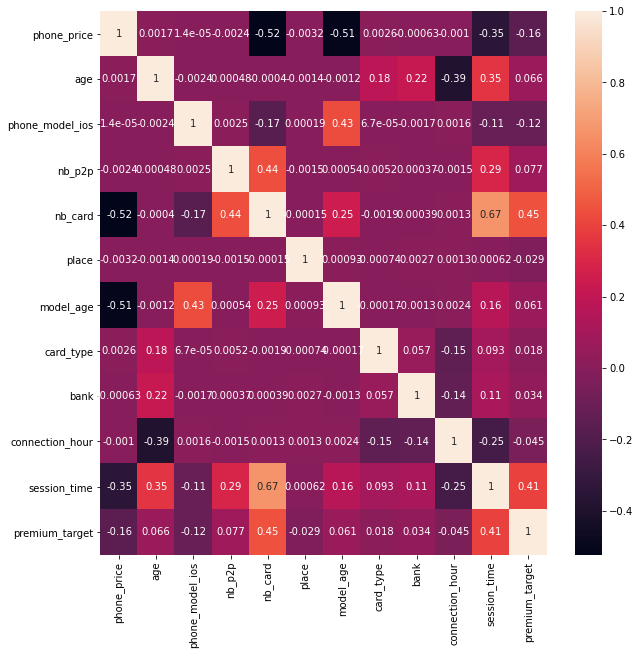

In [8]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)

The correlation matrix show pretty low correlations between variables, let's keep them all

## b. Continuous variables examination
For each variable we will: 
- Plot the density of both the premium and free users' distribution
- Compute the Kolmogorov-Smirnov test

> The Kolmogorov-Smirnov test evaluate how well a sample matchs a reference probability distribution (more info on wikipedia https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test)

> We use the ks_2samp Python implementation of the test in order to optain a metric on how similar are the premium and free users' distribution

Text(0.5, 1.0, 'Distribution of the phone price feature')

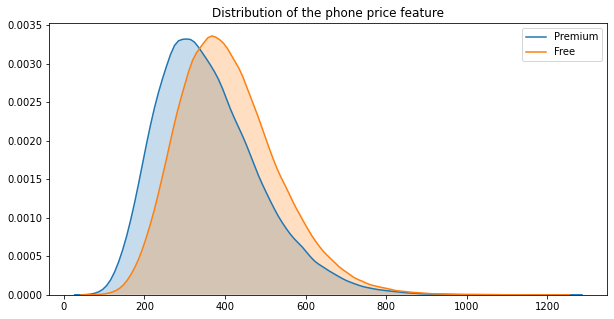

In [9]:
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data[data.premium_target==1].phone_price,shade=True,label='Premium')
ax = sns.kdeplot(data[data.premium_target==0].phone_price,shade=True,label='Free')
plt.title('Distribution of the phone price feature')

In [10]:
stat, pval = ks_2samp(data[data.premium_target==1].phone_price,data[data.premium_target==0].phone_price)
print(f"Kolmogorov-Smirnov test stat = {stat}, pvalue = {pval}" )

Kolmogorov-Smirnov test stat = 0.18037673211782274, pvalue = 0.0


The graph shows that premium users tends to have cheaper phones

Text(0.5, 1.0, 'Distribution of the age feature')

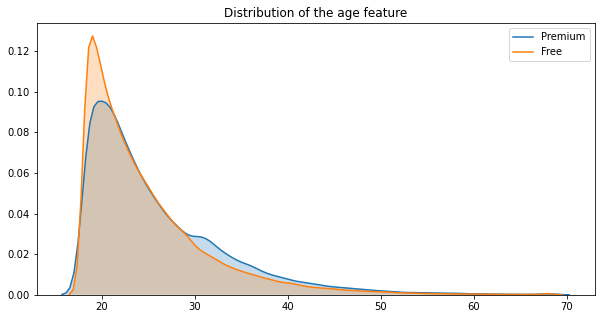

In [11]:
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data[data.premium_target==1].age,shade=True,label='Premium')
ax = sns.kdeplot(data[data.premium_target==0].age,shade=True,label='Free')
plt.title('Distribution of the age feature')

In [12]:
stat, pval = ks_2samp(data[data.premium_target==1].age,data[data.premium_target==0].age)
print(f"Kolmogorov-Smirnov test stat = {stat}, pvalue = {pval}" )

Kolmogorov-Smirnov test stat = 0.06473537550700148, pvalue = 1.2128594428510879e-179


Premium users tend to be older

Text(0.5, 1.0, 'Distribution of the number of payment feature')

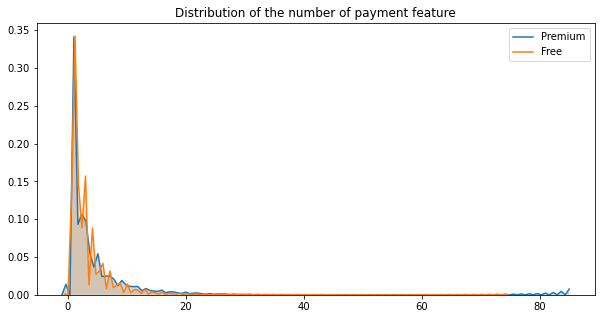

In [13]:
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data[data.premium_target==1].nb_p2p,shade=True,label='Premium')
ax = sns.kdeplot(data[data.premium_target==0].nb_p2p,shade=True,label='Free')
plt.title('Distribution of the number of payment feature')

In [14]:
stat, pval = ks_2samp(data[data.premium_target==1].nb_p2p,data[data.premium_target==0].nb_p2p)
print(f"Kolmogorov-Smirnov test stat = {stat}, pvalue = {pval}" )

Kolmogorov-Smirnov test stat = 0.055646481638454315, pvalue = 7.507089766033675e-133


The test aknowledge that this feature has an impact on being premium but the graph does not show clearly how

Text(0.5, 1.0, 'Distribution of the number of card feature')

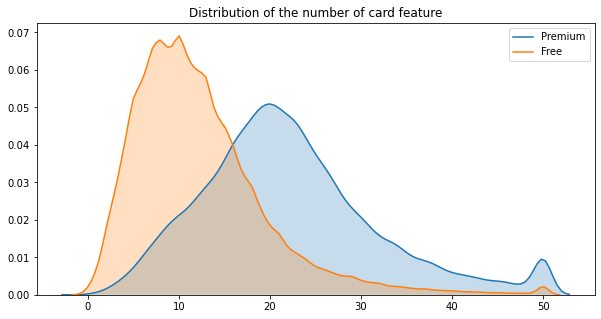

In [15]:
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data[data.premium_target==1].nb_card,shade=True,label='Premium')
ax = sns.kdeplot(data[data.premium_target==0].nb_card,shade=True,label='Free')
plt.title('Distribution of the number of card feature')

In [16]:
stat, pval = ks_2samp(data[data.premium_target==1].nb_card,data[data.premium_target==0].nb_card)
print(f"Kolmogorov-Smirnov test stat = {stat}, pvalue = {pval}" )

Kolmogorov-Smirnov test stat = 0.5057701119124015, pvalue = 0.0


This clearly shows that premium users have more cards than free users, this feature is a strong indicator

Text(0.5, 1.0, 'Distribution of age of the model age feature')

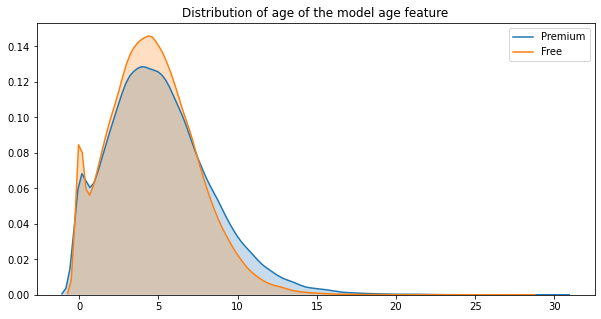

In [17]:
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data[data.premium_target==1].model_age,shade=True,label='Premium')
ax = sns.kdeplot(data[data.premium_target==0].model_age,shade=True,label='Free')
plt.title('Distribution of age of the model age feature')

In [18]:
stat, pval = ks_2samp(data[data.premium_target==1].model_age,data[data.premium_target==0].model_age)
print(f"Kolmogorov-Smirnov test stat = {stat}, pvalue = {pval}" )

Kolmogorov-Smirnov test stat = 0.059644472822255046, pvalue = 1.456618964210397e-152


We can see that premium users tend to have older phones

Text(0.5, 1.0, 'Distribution of the connection hour feature')

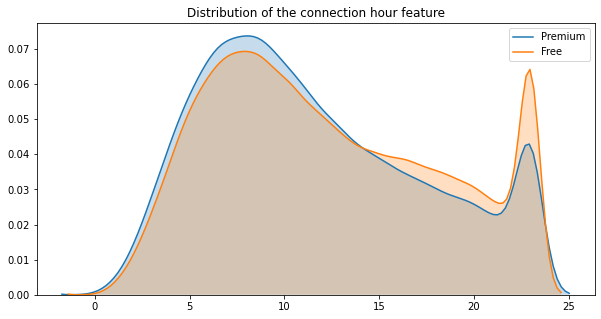

In [19]:
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data[data.premium_target==1].connection_hour,shade=True,label='Premium')
ax = sns.kdeplot(data[data.premium_target==0].connection_hour,shade=True,label='Free')
plt.title('Distribution of the connection hour feature')

In [20]:
stat, pval = ks_2samp(data[data.premium_target==1].connection_hour,data[data.premium_target==0].connection_hour)
print(f"Kolmogorov-Smirnov test stat = {stat}, pvalue = {pval}" )

Kolmogorov-Smirnov test stat = 0.04952435520307186, pvalue = 2.576547370059657e-105


Premium users use the product earlier in the day than free users. We can business-guess that the spike of connection in the evenning is due to users going out and sending monney to reimburse one another. 

Text(0.5, 1.0, 'Distribution of the session_time')

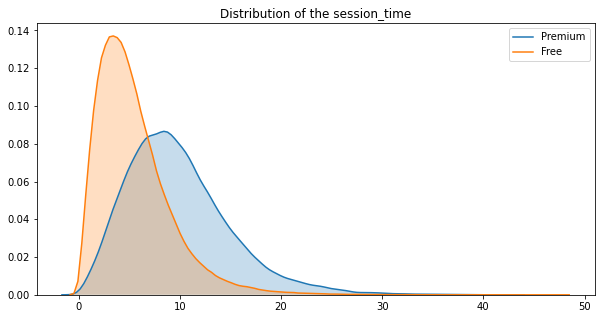

In [21]:
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data[data.premium_target==1].session_time,shade=True,label='Premium')
ax = sns.kdeplot(data[data.premium_target==0].session_time,shade=True,label='Free')
plt.title('Distribution of the session_time')

In [22]:
stat, pval = ks_2samp(data[data.premium_target==1].session_time,data[data.premium_target==0].session_time)
print(f"Kolmogorov-Smirnov test stat = {stat}, pvalue = {pval}" )

Kolmogorov-Smirnov test stat = 0.4207236642703715, pvalue = 0.0


This clearly show that paying users spend more time on the app than free users. We can guess that premium users have more thing to do on the app than free users.

## C. Discrete variables examination

Text(0.5, 1.0, 'Premium rate in android and ios users')

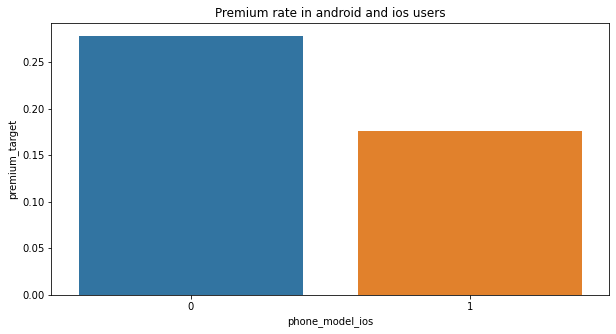

In [23]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x='phone_model_ios',y='premium_target',data=data,ci=None)
plt.title('Premium rate in android and ios users')

Most of the premium users have an android phone

Text(0.5, 1.0, 'Premium rate in place')

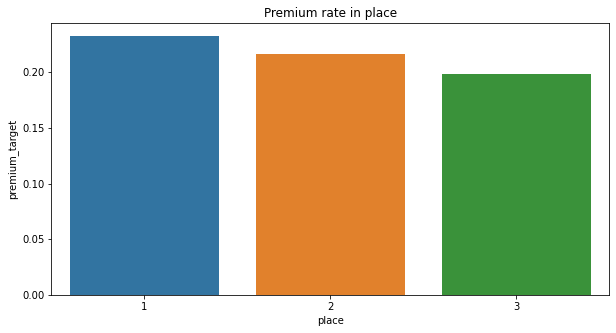

In [24]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x='place',y='premium_target',data=data,ci=None)
plt.title('Premium rate in place')

No clear link between being premium and places

Text(0.5, 1.0, 'Premium rate / card type')

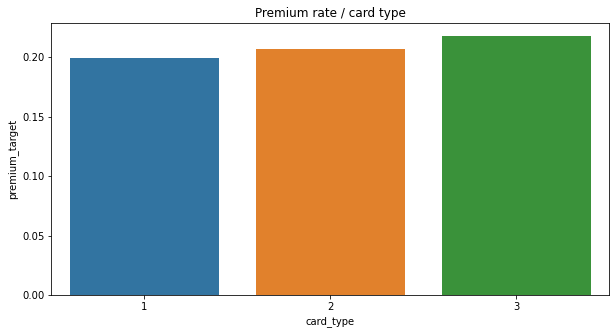

In [25]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x='card_type',y='premium_target',data=data,ci=None)
plt.title('Premium rate / card type')

The card type does not show an explicit influence

Text(0.5, 1.0, 'Premium rate per bank')

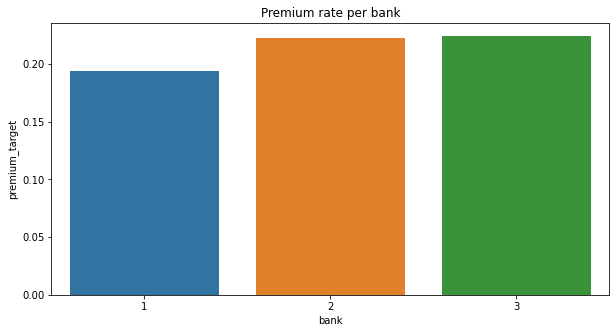

In [26]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x='bank',y='premium_target',data=data,ci=None)
plt.title('Premium rate per bank')

The bank does not seemns to influence greatly the rate of premium users

# II. Clustering Analysis

In [27]:
X, y = data.drop(['premium_target'],axis=1,inplace=False), data['premium_target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=44)

In [28]:
kmeans = KMeans(n_clusters=30)#starting with a large number of cluster
y_kmeans = kmeans.fit_predict(X_train)

In [29]:
res_data = {'clusters':y_kmeans,'premium_target': y_train}
result = pd.DataFrame(res_data)

In [30]:
#calculating the rate of premium users in each clusters 
(result[result.premium_target==1].groupby('clusters').count()/result.groupby('clusters').count()).sort_values(by=['premium_target'],ascending=False)

,premium_target
clusters,
7,0.603238
16,0.597875
9,0.562573
3,0.478726
18,0.397326
23,0.360035
11,0.248917
20,0.244529
27,0.200696


Text(0.5, 1.0, 'Premium rate per cluster')

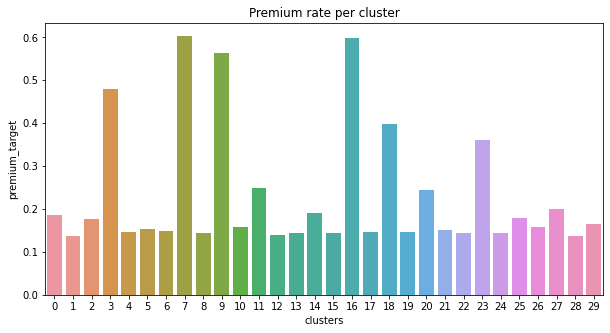

In [31]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x='clusters',y='premium_target',data=result,ci=None)
plt.title('Premium rate per cluster')

We can see that the rate of premium users is significally larger, up to 60%, in clusters 7,9 and 16. We can say that the algorithm successfully grouped premium users in a few clustes.

In [32]:
#Now checking on the test dataset that the model generalize well 
y_kmeans_test = kmeans.predict(X_test)
res_data_test = {'clusters':y_kmeans_test,'premium_target': y_test}
result_test = pd.DataFrame(res_data_test)

In [33]:
(result_test[result_test.premium_target==1].groupby('clusters').count()/result_test.groupby('clusters').count()).sort_values(by=['premium_target'],ascending=False)

,premium_target
clusters,
7,0.599585
16,0.576577
9,0.559905
3,0.479893
18,0.406593
23,0.377392
11,0.250449
20,0.231990
5,0.209302


Text(0.5, 1.0, 'clusters')

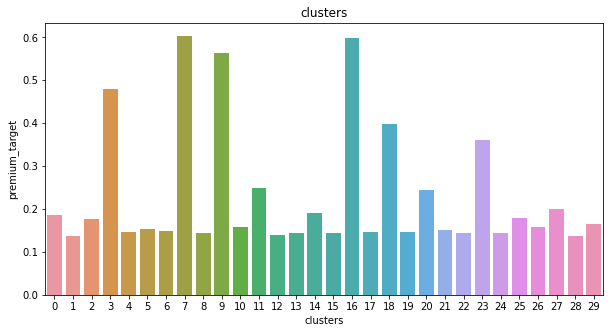

In [34]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x='clusters',y='premium_target',data=result,ci=None)
plt.title('clusters')

Results of the test dataset show that the agorithm is working and showing similar results on the train and test dataset.
Finally we can train the model on the whole dataset and identify our 2000 target users

In [35]:
kmeans = KMeans(n_clusters=30)
y_kmeans = kmeans.fit_predict(X)
res_data = {'clusters':y_kmeans,'premium_target': y}
result = pd.DataFrame(res_data)
(result[result.premium_target==1].groupby('clusters').count()/result.groupby('clusters').count()).sort_values(by=['premium_target'],ascending=False)

,premium_target
clusters,
0,0.606885
10,0.589205
27,0.574898
15,0.556514
24,0.471927
18,0.405973
14,0.295349
6,0.243112
29,0.230036


We can see that the highest premium rate are in clusters 0 and 10, therefore we should pick our target in those clusters.

In [52]:
result[result.premium_target==0].groupby('clusters').count() #displaying the number of free user per cluster

,premium_target
clusters,
0,1633
1,10664
2,14156
3,4777
4,14298
5,743
6,11703
7,7253
8,3653


We should then pick 1633 users in cluster 0 and 377 in cluster 10

# III. Classification

In [36]:
X, y = data.drop(['premium_target'],axis=1,inplace=False), data['premium_target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=44)

In [37]:
model = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=5)

In [38]:
cv_res = cross_validate(model,X_train,y_train,cv=kfold,scoring=('roc_auc','accuracy'))

In [39]:
print(f"After 5 folds: - roc auc score: {cv_res['test_roc_auc'].mean()} std:{cv_res['test_roc_auc'].std()} - accuracy mean: {cv_res['test_accuracy'].mean()} std: {cv_res['test_accuracy'].std()}")

After 5 folds: - roc auc score: 0.8825813198700173 std:0.002768846409865778 - accuracy mean: 0.8478249999999999 std: 0.001964290584409538


The score results are good, wen can conclude that the model is working. Let's try to improve the performance by tunning the hyper parameters through a GridSearch

In [40]:
#Only a few options are explored here due to lack of computing power 
param = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,None],
    'min_samples_leaf' : [1,5,10],
    'n_estimators' : [10,100]
}
g_search = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid = param, scoring='roc_auc',n_jobs=-1,iid=False, cv=5
                       )
g_search.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, estimator=RandomForestClassifier(), iid=False, n_jobs=-1,
             param_grid={'max_depth': [10, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [10, 100]},
             scoring='roc_auc')

In [41]:
print(g_search.best_params_, g_search.best_score_)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100} 0.8858820628233623


In [45]:
#trainning the model with the best parameters 
best_model = RandomForestClassifier(max_depth = None, max_features='sqrt', min_samples_leaf = 10, n_estimators = 100)
best_model.fit(X_train,y_train)

RandomForestClassifier(max_features='sqrt', min_samples_leaf=10)

In [46]:
#testing the model on the test set
y_pred = best_model.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print(f"roc auc score on the test set is {score}")

roc auc score on the test set is 0.7643041097133909


The score on the test set is positive; we can train this model on the whole data set

In [47]:
best_model.fit(X,y)
y_pred = best_model.predict_proba(X) #this method returns the 'probability' that each sample belong to each class

In [48]:
best_model.classes_ #finding out which column correspond to which class

array([0, 1])

Finally we can prepare the list of targeted users by taking the 2000 free users most likely to be premium

In [49]:
users_targeted = X.copy()
users_targeted['premium_target'] = y
users_targeted['predicted_score'] = y_pred[:,1]

In [50]:
#taking only free users (premium target == 0) and sorting samples by descending predicted_score
users_targeted = users_targeted[users_targeted['premium_target']==0][['predicted_score']].sort_values('predicted_score',ascending=False)
users_targeted = users_targeted.head(2000) #the top 2000 samples are the free users most likely to be premium

In [53]:
users_targeted

,predicted_score
299452,0.714775
42818,0.711041
233333,0.708783
229380,0.703310
2373,0.702189
...,...
75105,0.601045
104400,0.600966
128507,0.600952
203828,0.600952
